# Victor's Experiments

Slides:
1) Welcome: project name, students names
2) Intro: problem, applications, solution, work references, target
3) Data info
4) Initial work: collecting data, split data, classifier as a reference, plotting score and confusion matrix
5) Features extracting:
    - Speech anatomy
    - Speech analysis
    - Speach emotions patterns
    - Time-domain features
    - Frequency-domain processing: STFT, Spectrogram, MFCC
    - Frequency-domain features
    - ...
    - MiniRocket tool
    - Feature analysis, selecting features
6) GridSearch for best classification model with different hyperparameters:
    - KNN
    - SVC
    - LogRegression
    - RandomForest
7) Select best model, train and test, plotting score and confusion matrix
8) Conclusion, further work
9) Thank you

In [1]:
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import librosa
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import VictorLib as lib

C:\Users\VUGAR\AppData\Local\Temp\ipykernel_5084\3916351602.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Parameters

FRAME_LENGTH = 1024
HOP_LENGTH = 512

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

## Analyze data

In [11]:
sample, sr = librosa.load('cremad/AudioWAV/1001_DFA_ANG_XX.wav')
display(sample.shape)
display(np.isfinite(sample).all())
Audio(data=sample, rate=sr)

(50177,)

True

In [12]:
# Noise Reduction
import noisereduce as nr
sample_nr = nr.reduce_noise(y=sample, sr=sr)
display(sample_nr.shape)
display(np.isfinite(sample_nr).all())
Audio(data=sample_nr, rate=sr)

(50177,)

True

In [3]:
# Load normal voice 1
sample_normal_1, FsN1 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
display(sample_normal_1.shape)
Audio(data=sample_normal_1, rate=FsN1)

C:\Users\VUGAR\AppData\Local\Temp\ipykernel_5084\3112848205.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  sample_normal_1, FsN1 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
c:\ProgramData\anaconda3\envs\MyEnv\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'data/ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'

In [ ]:
# Load very stressed voice 1
sample_fear_1, FsF1 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_01/03-01-06-02-01-01-01.wav')
display(sample_fear_1.shape)
Audio(data=sample_fear_1, rate=FsF1)

(110361,)

In [ ]:
# Load normal voice 2
sample_normal_2, FsN2 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav')
display(sample_normal_2.shape)
Audio(data=sample_normal_2, rate=FsN2)

(80195,)

In [ ]:
# Load very stressed voice 2
sample_fear_2, FsF2 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_02/03-01-06-02-01-01-02.wav')
display(sample_fear_2.shape)
Audio(data=sample_fear_2, rate=FsF2)

(83874,)

In [ ]:
# Load normal voice 3
sample_normal_3, FsN3 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_03/03-01-01-01-01-01-03.wav')
display(sample_normal_3.shape)
Audio(data=sample_normal_3, rate=FsN3)

(75781,)

In [ ]:
# Load very stressed voice 2
sample_fear_3, FsF3 = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_03/03-01-06-02-01-01-03.wav')
display(sample_fear_3.shape)
Audio(data=sample_fear_3, rate=FsF3)

(72839,)

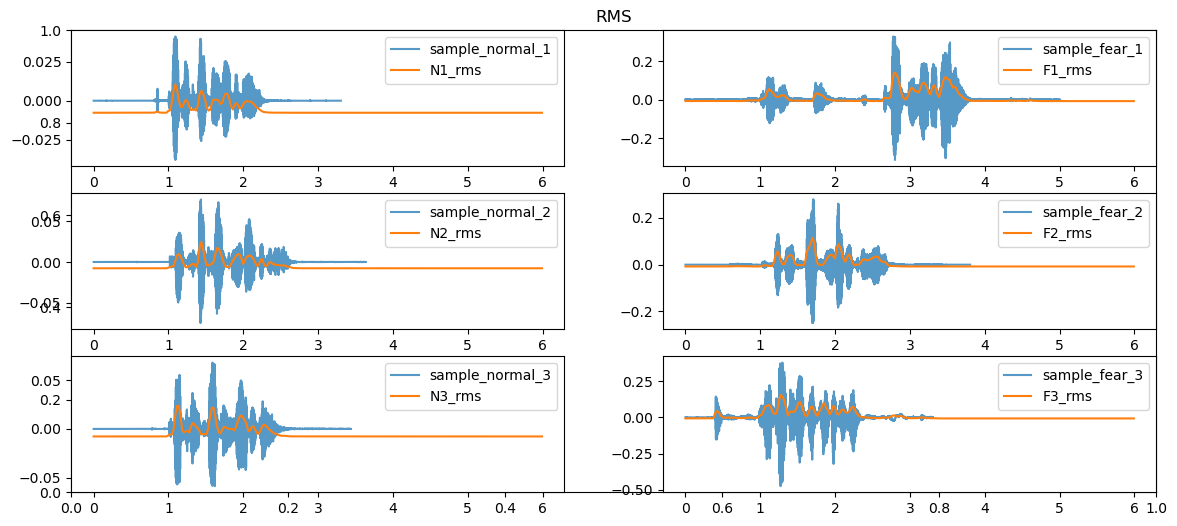

In [ ]:
# RMS
NF3 = np.zeros([6,3*44100],dtype=np.float32)
NF3[0][:len(sample_normal_1)] = sample_normal_1
NF3[1][:len(sample_normal_2)] = sample_normal_2
NF3[2][:len(sample_normal_3)] = sample_normal_3
NF3[3][:len(sample_fear_1)] = sample_fear_1
NF3[4][:len(sample_fear_2)] = sample_fear_2
NF3[5][:len(sample_fear_3)] = sample_fear_3
NF3_rms, NF3_rms_features = lib.GetRmsFeatures(NF3)

WN1 = ['sample_normal_1',sample_normal_1,FsN1,np.array([0,1])] # axis=3 : zoom in time
WN2 = ['sample_normal_2',sample_normal_2,FsN2,np.array([0,1])]
WN3 = ['sample_normal_3',sample_normal_3,FsN3,np.array([0,1])]
WF1 = ['sample_fear_1',sample_fear_1,FsF1,np.array([0,1])]
WF2 = ['sample_fear_2',sample_fear_2,FsF2,np.array([0,1])]
WF3 = ['sample_fear_3',sample_fear_3,FsF3,np.array([0,1])]
rmsN1 = [['N1_rms',NF3_feat[0]]]
rmsN2 = [['N2_rms',NF3_rms[1]]]
rmsN3 = [['N3_rms',NF3_rms[2]]]
rmsF1 = [['F1_rms',NF3_rms[3]]]
rmsF2 = [['F2_rms',NF3_rms[4]]]
rmsF3 = [['F3_rms',NF3_rms[5]]]
lib.PlotFeaturesAnalysis('RMS',WN1,WN2,WN3,WF1,WF2,WF3,rmsN1,rmsN2,rmsN3,rmsF1,rmsF2,rmsF3)

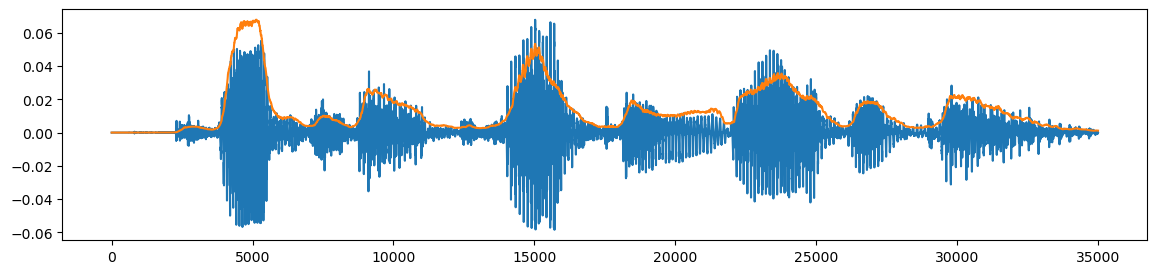

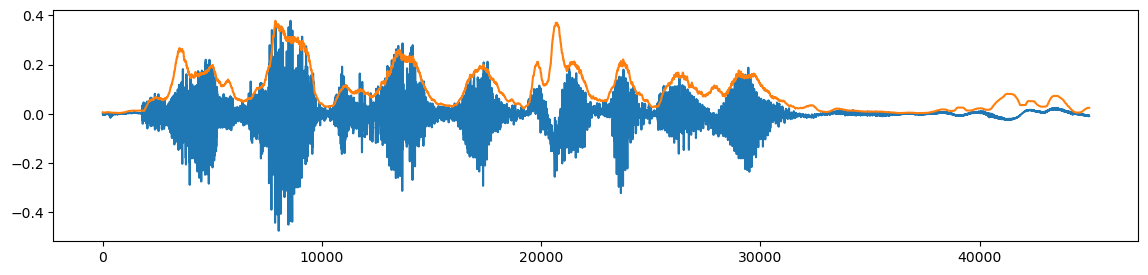

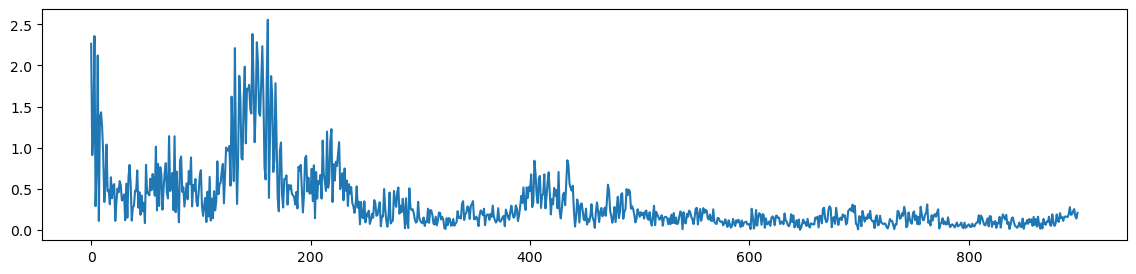

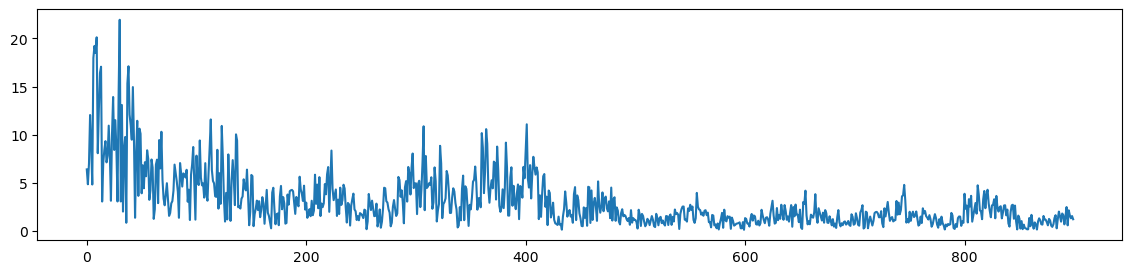

5145

7872

467.2675107896258

4094.661147630184

161

30

'\nN1_rms_mean, N1_rms_var, N1_rms_freg, N1_rms_cross = GetMeanVarFreqCrossFromTimeDomain_1sample(sample_normal_1)\nF1_rms_mean, F1_rms_var, F1_rms_freg, F1_rms_cross = GetMeanVarFreqCrossFromTimeDomain_1sample(sample_fear_1)\nfeatures = np.array([[N1_rms_mean, N1_rms_var, N1_rms_freg, N1_rms_cross], [F1_rms_mean, F1_rms_var, F1_rms_freg, F1_rms_cross]])\ndisplay(features)\n\ntemp = sample_normal_1 / rms_norm_1(librosa.frames_to_time(frames=range(len(rms_norm_1)),hop_length=HOP_LENGTH))\nplt.plot(temp)\n'

In [ ]:
# Trying to analyze RMS features from time-domain

def PlotRms(sample,time):
    frame_size = 512
    hop_size = 1
    half_frame_size = (int)(frame_size/2)
    fRms = np.zeros(sample.shape)
    for ii in range(0,len(sample),hop_size):
        frame = sample[ii:ii+frame_size]
        fRms[ii] = np.sqrt(np.median(np.square(frame)))
    fRms *= np.max(sample)/np.max(fRms)
    fRms = np.roll(fRms,300)
    plt.figure(figsize=(14, 3))
    lib.ZoomIn([sample,fRms],time)
    plt.show()
    return fRms[time[0]:time[1]]

def PlotFFT(sample,time):
    plt.figure(figsize=(14, 3))
    SampleN1 = np.abs(np.fft.fft(sample))
    plt.plot(SampleN1[time[0]:time[1]])
    plt.show()
    return SampleN1[time[0]:time[1]]

sample1 = sample_normal_3
sample2 = sample_fear_3
fRmsN1 = PlotRms(sample1, [20000,55000]) #[21900,26000]
fRmsF1 = PlotRms(sample2, [20000,65000]) #[21900,26000]
fRmsArgmaxN1 = np.argmax(fRmsN1)
fRmsArgmaxF1 = np.argmax(fRmsF1)
fRmsSumN1 = np.sum(fRmsN1)
fRmsSumF1 = np.sum(fRmsF1)
fRmsN1 = fRmsN1-np.mean(fRmsN1)
fRmsF1 = fRmsF1-np.mean(fRmsF1)
fRmsFftN1 = PlotFFT(fRmsN1,[100,1000])
fRmsFftF1 = PlotFFT(fRmsF1,[100,1000])
fRmsFftArgmaxN1 = np.argmax(fRmsFftN1)
fRmsFftArgmaxF1 = np.argmax(fRmsFftF1)

display(fRmsArgmaxN1)
display(fRmsArgmaxF1)
display(fRmsSumN1)
display(fRmsSumF1)
display(fRmsFftArgmaxN1)
display(fRmsFftArgmaxF1)

#f = interpolate.interp1d(x, y)

'''
fContour = librosa.feature.rms(y=sample_normal_1,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
lib.SubPlotWavFeat(1,1,1,FsN1,sample_normal_1,fContour,'sample_normal_1','rms_norm_1')
'''

'''
N1_rms_mean, N1_rms_var, N1_rms_freg, N1_rms_cross = GetMeanVarFreqCrossFromTimeDomain_1sample(sample_normal_1)
F1_rms_mean, F1_rms_var, F1_rms_freg, F1_rms_cross = GetMeanVarFreqCrossFromTimeDomain_1sample(sample_fear_1)
features = np.array([[N1_rms_mean, N1_rms_var, N1_rms_freg, N1_rms_cross], [F1_rms_mean, F1_rms_var, F1_rms_freg, F1_rms_cross]])
display(features)

temp = sample_normal_1 / rms_norm_1(librosa.frames_to_time(frames=range(len(rms_norm_1)),hop_length=HOP_LENGTH))
plt.plot(temp)
'''

ValueError: invalid literal for int() with base 10: 'sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

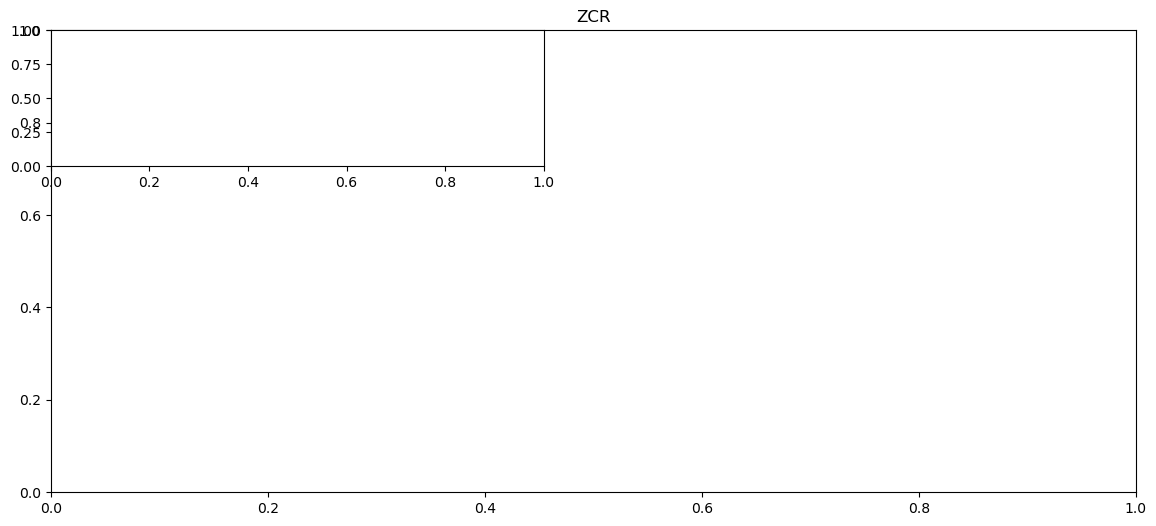

In [ ]:
# Zero Crossing Rate
zcr_norm_1 = librosa.feature.zero_crossing_rate(y=sample_normal_1,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
zcr_norm_2 = librosa.feature.zero_crossing_rate(y=sample_normal_2,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
zcr_norm_3 = librosa.feature.zero_crossing_rate(y=sample_normal_3,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
zcr_fear_1 = librosa.feature.zero_crossing_rate(y=sample_fear_1,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
zcr_fear_2 = librosa.feature.zero_crossing_rate(y=sample_fear_2,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]
zcr_fear_3 = librosa.feature.zero_crossing_rate(y=sample_fear_3,frame_length=FRAME_LENGTH,hop_length=HOP_LENGTH)[0]

#zcr_sample1 = 100 * zcr_sample1 * rms_sample1
#zcr_sample2 = 100 * zcr_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('ZCR')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,zcr_norm_1,'sample_normal_1','zcr_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,zcr_fear_1,'sample_fear_1','zcr_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,zcr_norm_2,'sample_normal_2','zcr_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,zcr_fear_2,'sample_fear_2','zcr_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,zcr_norm_3,'sample_normal_3','zcr_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,zcr_fear_3,'sample_fear_3','zcr_fear_3')
plt.show()

In [ ]:
# spectral_centroid
spec_cent_norm_1 = librosa.feature.spectral_centroid(y=sample_normal_1,hop_length=HOP_LENGTH)[0]
spec_cent_norm_2 = librosa.feature.spectral_centroid(y=sample_normal_2,hop_length=HOP_LENGTH)[0]
spec_cent_norm_3 = librosa.feature.spectral_centroid(y=sample_normal_3,hop_length=HOP_LENGTH)[0]
spec_cent_fear_1 = librosa.feature.spectral_centroid(y=sample_fear_1,hop_length=HOP_LENGTH)[0]
spec_cent_fear_2 = librosa.feature.spectral_centroid(y=sample_fear_2,hop_length=HOP_LENGTH)[0]
spec_cent_fear_3 = librosa.feature.spectral_centroid(y=sample_fear_3,hop_length=HOP_LENGTH)[0]

#sc_sample1 = 0.005 * sc_sample1 * rms_sample1
#sc_sample2 = 0.005 * sc_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('spectral_centroid')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,spec_cent_norm_1,'sample_normal_1','spec_cent_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,spec_cent_fear_1,'sample_fear_1','spec_cent_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,spec_cent_norm_2,'sample_normal_2','spec_cent_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,spec_cent_fear_2,'sample_fear_2','spec_cent_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,spec_cent_norm_3,'sample_normal_3','spec_cent_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,spec_cent_fear_3,'sample_fear_3','spec_cent_fear_3')
plt.show()

In [ ]:
# spectral_bandwidth
spec_bw_norm_1 = librosa.feature.spectral_bandwidth(y=sample_normal_1,hop_length=HOP_LENGTH)[0]
spec_bw_norm_2 = librosa.feature.spectral_bandwidth(y=sample_normal_2,hop_length=HOP_LENGTH)[0]
spec_bw_norm_3 = librosa.feature.spectral_bandwidth(y=sample_normal_3,hop_length=HOP_LENGTH)[0]
spec_bw_fear_1 = librosa.feature.spectral_bandwidth(y=sample_fear_1,hop_length=HOP_LENGTH)[0]
spec_bw_fear_2 = librosa.feature.spectral_bandwidth(y=sample_fear_2,hop_length=HOP_LENGTH)[0]
spec_bw_fear_3 = librosa.feature.spectral_bandwidth(y=sample_fear_3,hop_length=HOP_LENGTH)[0]

#sb_sample1 = 0.005 * sb_sample1 * rms_sample1
#sb_sample2 = 0.005 * sb_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('spectral_bandwidth')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,spec_bw_norm_1,'sample_normal_1','spec_bw_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,spec_bw_fear_1,'sample_fear_1','spec_bw_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,spec_bw_norm_2,'sample_normal_2','spec_bw_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,spec_bw_fear_2,'sample_fear_2','spec_bw_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,spec_bw_norm_3,'sample_normal_3','spec_bw_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,spec_bw_fear_3,'sample_fear_3','spec_bw_fear_3')
plt.show()

In [ ]:
# spectral_contrast
spec_cont_norm_1 = librosa.feature.spectral_contrast(y=sample_normal_1,hop_length=HOP_LENGTH)[0]
spec_cont_norm_2 = librosa.feature.spectral_contrast(y=sample_normal_2,hop_length=HOP_LENGTH)[0]
spec_cont_norm_3 = librosa.feature.spectral_contrast(y=sample_normal_3,hop_length=HOP_LENGTH)[0]
spec_cont_fear_1 = librosa.feature.spectral_contrast(y=sample_fear_1,hop_length=HOP_LENGTH)[0]
spec_cont_fear_2 = librosa.feature.spectral_contrast(y=sample_fear_2,hop_length=HOP_LENGTH)[0]
spec_cont_fear_3 = librosa.feature.spectral_contrast(y=sample_fear_3,hop_length=HOP_LENGTH)[0]

#sb_sample1 = 0.1 * sb_sample1 * rms_sample1
#sb_sample2 = 0.1 * sb_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('spectral_contrast')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,spec_cont_norm_1,'sample_normal_1','spec_cont_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,spec_cont_fear_1,'sample_fear_1','spec_cont_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,spec_cont_norm_2,'sample_normal_2','spec_cont_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,spec_cont_fear_2,'sample_fear_2','spec_cont_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,spec_cont_norm_3,'sample_normal_3','spec_cont_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,spec_cont_fear_3,'sample_fear_3','spec_cont_fear_3')
plt.show()

In [ ]:
# spectral_flatness
spec_flat_norm_1 = librosa.feature.spectral_flatness(y=sample_normal_1,hop_length=HOP_LENGTH)[0]
spec_flat_norm_2 = librosa.feature.spectral_flatness(y=sample_normal_2,hop_length=HOP_LENGTH)[0]
spec_flat_norm_3 = librosa.feature.spectral_flatness(y=sample_normal_3,hop_length=HOP_LENGTH)[0]
spec_flat_fear_1 = librosa.feature.spectral_flatness(y=sample_fear_1,hop_length=HOP_LENGTH)[0]
spec_flat_fear_2 = librosa.feature.spectral_flatness(y=sample_fear_2,hop_length=HOP_LENGTH)[0]
spec_flat_fear_3 = librosa.feature.spectral_flatness(y=sample_fear_3,hop_length=HOP_LENGTH)[0]

#sb_sample1 = 200 * sb_sample1 * rms_sample1
#sb_sample2 = 200 * sb_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('spectral_flatness')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,spec_flat_norm_1,'sample_normal_1','spec_flat_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,spec_flat_fear_1,'sample_fear_1','spec_flat_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,spec_flat_norm_2,'sample_normal_2','spec_flat_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,spec_flat_fear_2,'sample_fear_2','spec_flat_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,spec_flat_norm_3,'sample_normal_3','spec_flat_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,spec_flat_fear_3,'sample_fear_3','spec_flat_fear_3')
plt.show()

In [ ]:
# spectral_rolloff
spec_roll_norm_1 = librosa.feature.spectral_rolloff(y=sample_normal_1,hop_length=HOP_LENGTH)[0]
spec_roll_norm_2 = librosa.feature.spectral_rolloff(y=sample_normal_2,hop_length=HOP_LENGTH)[0]
spec_roll_norm_3 = librosa.feature.spectral_rolloff(y=sample_normal_3,hop_length=HOP_LENGTH)[0]
spec_roll_fear_1 = librosa.feature.spectral_rolloff(y=sample_fear_1,hop_length=HOP_LENGTH)[0]
spec_roll_fear_2 = librosa.feature.spectral_rolloff(y=sample_fear_2,hop_length=HOP_LENGTH)[0]
spec_roll_fear_3 = librosa.feature.spectral_rolloff(y=sample_fear_3,hop_length=HOP_LENGTH)[0]

#sb_sample1 = 0.001 * sb_sample1 * rms_sample1
#sb_sample2 = 0.001 * sb_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('spectral_rolloff')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,spec_roll_norm_1,'sample_normal_1','spec_roll_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,spec_roll_fear_1,'sample_fear_1','spec_roll_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,spec_roll_norm_2,'sample_normal_2','spec_roll_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,spec_roll_fear_2,'sample_fear_2','spec_roll_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,spec_roll_norm_3,'sample_normal_3','spec_roll_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,spec_roll_fear_3,'sample_fear_3','spec_roll_fear_3')
plt.show()

In [ ]:
# tonnetz
tonnetz_norm_1 = librosa.feature.tonnetz(y=sample_normal_1,hop_length=HOP_LENGTH)[0]
tonnetz_norm_2 = librosa.feature.tonnetz(y=sample_normal_2,hop_length=HOP_LENGTH)[0]
tonnetz_norm_3 = librosa.feature.tonnetz(y=sample_normal_3,hop_length=HOP_LENGTH)[0]
tonnetz_fear_1 = librosa.feature.tonnetz(y=sample_fear_1,hop_length=HOP_LENGTH)[0]
tonnetz_fear_2 = librosa.feature.tonnetz(y=sample_fear_2,hop_length=HOP_LENGTH)[0]
tonnetz_fear_3 = librosa.feature.tonnetz(y=sample_fear_3,hop_length=HOP_LENGTH)[0]

#sb_sample1 = 50 * sb_sample1 * rms_sample1
#sb_sample2 = 50 * sb_sample2 * rms_sample2

plt.figure(figsize=(14, 6))
plt.title('tonnetz')
lib.SubPlotWavFeat(3,2,1,FsN1,sample_normal_1,tonnetz_norm_1,'sample_normal_1','tonnetz_norm_1')
lib.SubPlotWavFeat(3,2,2,FsF1,sample_fear_1,tonnetz_fear_1,'sample_fear_1','tonnetz_fear_1')
lib.SubPlotWavFeat(3,2,3,FsN2,sample_normal_2,tonnetz_norm_2,'sample_normal_2','tonnetz_norm_2')
lib.SubPlotWavFeat(3,2,4,FsF2,sample_fear_2,tonnetz_fear_2,'sample_fear_2','tonnetz_fear_2')
lib.SubPlotWavFeat(3,2,5,FsN3,sample_normal_3,tonnetz_norm_3,'sample_normal_3','tonnetz_norm_3')
lib.SubPlotWavFeat(3,2,6,FsF3,sample_fear_3,tonnetz_fear_3,'sample_fear_3','tonnetz_fear_3')
plt.show()

In [ ]:
# STFT
stft_sample1 = librosa.stft(y=sample1,hop_length=HOP_LENGTH)
stft_sample2 = librosa.stft(y=sample2,hop_length=HOP_LENGTH)

stft_sample1_db = librosa.amplitude_to_db(stft_sample1)
stft_sample2_db = librosa.amplitude_to_db(stft_sample2)

fig = plt.figure(figsize=(14, 6))
img = librosa.display.specshow(stft_sample1_db, x_axis='time',y_axis='log')
fig.colorbar(img,format=f'%0.2f')
plt.show()
fig = plt.figure(figsize=(14, 6))
img = librosa.display.specshow(stft_sample2_db, x_axis='time',y_axis='log')
fig.colorbar(img,format=f'%0.2f')
plt.show()

In [ ]:
# Mel features extraction

display(sample1.shape)
display(sample2.shape)
sample1_mel = librosa.feature.melspectrogram(y=sample1)
sample2_mel = librosa.feature.melspectrogram(y=sample2)
sample1_mel_db = librosa.amplitude_to_db(sample1_mel)
sample2_mel_db = librosa.amplitude_to_db(sample2_mel)
display(sample1_mel_db.shape)
display(sample2_mel_db.shape)
sample1_mfcc = librosa.feature.mfcc(y=sample1, n_mfcc=40)
sample2_mfcc = librosa.feature.mfcc(y=sample2, n_mfcc=40)
display(sample1_mfcc.shape)
display(sample2_mfcc.shape)

# Plot Mel-spectogram
fig = plt.figure(figsize=(14, 6))
img = librosa.display.specshow(sample1_mel_db, x_axis='time',y_axis='log')
fig.colorbar(img,format=f'%0.2f')
plt.show()
fig = plt.figure(figsize=(14, 6))
img = librosa.display.specshow(sample2_mel_db, x_axis='time',y_axis='log')
fig.colorbar(img,format=f'%0.2f')
plt.show()
fig = plt.figure(figsize=(14, 6))
img = librosa.display.specshow(sample1_mfcc, x_axis='time',y_axis='log')
fig.colorbar(img,format=f'%0.2f')
plt.show()
fig = plt.figure(figsize=(14, 6))
img = librosa.display.specshow(sample2_mfcc, x_axis='time',y_axis='log')
fig.colorbar(img,format=f'%0.2f')
plt.show()


## Machine Learning

### Preprocessing

In [3]:
# Collect data
max_len = 0
i=0
num_of_experiments = 24*2*2*(7*2+1)
sampled_data = np.zeros([num_of_experiments,3*44100],dtype=np.float32)
labels = np.zeros([num_of_experiments,5],dtype=np.uint8)
for i_actor in range(1,24+1,1):
    for i_statement in range(1,2+1,1):
        for i_repetition in range(1,2+1,1):
            for i_intensity in range(1,2+1,1):
                for i_emothion in range(1,8+1,1):
                    if i_emothion==1 and i_intensity!=1:
                        continue
                    new_sample, *_ = librosa.load(f'data/ravdess/audio_speech_actors_01-24/Actor_{i_actor:02d}/03-01-{i_emothion:02d}-{i_intensity:02d}-{i_statement:02d}-{i_repetition:02d}-{i_actor:02d}.wav')
                    if new_sample.size > max_len:
                        max_len = new_sample.size
                    sampled_data[i,:new_sample.size] = new_sample.reshape(1,new_sample.size)
                    labels[i,0] = i_actor
                    labels[i,1] = i_statement
                    labels[i,2] = i_repetition
                    labels[i,3] = i_intensity
                    labels[i,4] = i_emothion
                    i += 1

display(sampled_data.shape)
display(labels.shape)

(1440, 132300)

(1440, 5)

### Feature Extraction

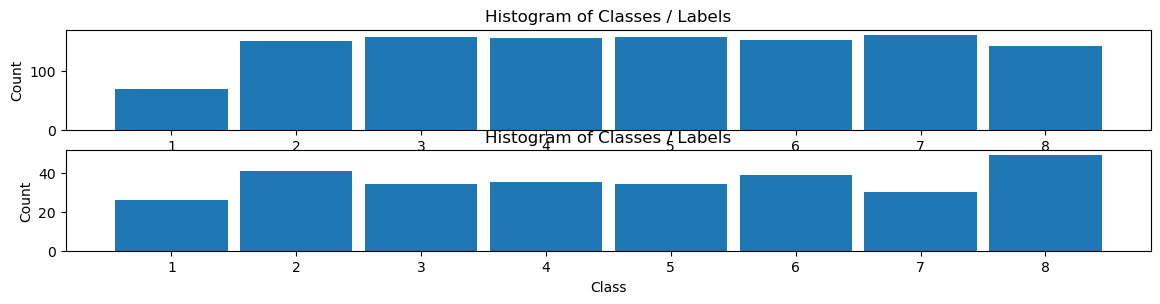

(1152, 132300)

(1152,)

(288, 132300)

(288,)

{'core_sample_indices': array([   0,    1,    2,    3,    6,    7,    8,   10,   15,   16,   18,
          21,   22,   23,   30,   31,   32,   33,   36,   37,   38,   45,
          46,   47,   48,   51,   52,   53,   60,   61,   63,   66,   68,
          70,   75,   76,   78,   81,   83,   85,   91,   93,   98,  100,
         106,  108,  113,  115,  120,  121,  123,  124,  125,  135,  136,
         138,  141,  150,  151,  153,  156,  168,  180,  181,  183,  188,
         195,  196,  203,  210,  211,  218,  225,  226,  233,  240,  241,
         242,  243,  245,  246,  247,  248,  249,  250,  253,  255,  256,
         257,  258,  260,  261,  263,  265,  270,  271,  272,  273,  274,
         275,  276,  277,  278,  280,  285,  286,  288,  291,  293,  295,
         298,  300,  301,  302,  303,  304,  305,  306,  307,  308,  314,
         315,  316,  318,  319,  320,  321,  322,  323,  325,  328,  330,
         331,  332,  333,  335,  336,  337,  338,  345,  346,  348,  350,
         351,  

In [6]:
# mini rocket

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.datasets import (
    load_japanese_vowels,  # multivariate dataset with unequal length
)

'''
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
display(X_train.shape)
display(y_train.shape)
# visualize the first univariate time series
X_train.iloc[0, 0].plot()

minirocket = MiniRocket()  # by default, MiniRocket uses ~10_000 kernels
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
# test shape of transformed training data -> (n_instances, 9_996)
display(X_train_transform.shape)

scaler = StandardScaler(with_mean=False)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
X_train_scaled_transform = scaler.fit_transform(X_train_transform)
display(X_train_scaled_transform.shape)
classifier.fit(X_train_scaled_transform, y_train)

X_test, y_test = load_arrow_head(split="test", return_X_y=True)
display(X_test.shape)
display(X_test.shape)
X_test_transform = minirocket.transform(X_test)
display(X_test_transform.shape)

X_test_scaled_transform = scaler.transform(X_test_transform)
display(X_test_scaled_transform.shape)
classifier.score(X_test_scaled_transform, y_test)
'''

'''
# step 3 - specify the classifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
# example 1 - 3-NN with simple dynamic time warping distance (requires numba)
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3)
# example 2 - custom distance:
# 3-nearest neighbour classifier with Euclidean distance (on flattened time series)
# (requires scipy)
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist
eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)

clf.fit(train_data, train_labels)

clf.score(test_data,test_labels)
'''

# steps 1, 2 - prepare osuleaf dataset (train and new)
train_data,train_labels,test_data,test_labels = lib.PlotSplitData(sampled_data,labels[:,4],trainRatio=0.8)
display(train_data.shape)
display(train_labels.shape)
display(test_data.shape)
display(test_labels.shape)

# step 2 - specify the clusterer
from sktime.clustering.dbscan import TimeSeriesDBSCAN
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clst = TimeSeriesDBSCAN(distance=eucl_dist, eps=2)

# step 3 - fit the clusterer to the data
clst.fit(sampled_data)

# step 4 - inspect the clustering
clst.get_fitted_params()

In [10]:
params = clst.get_fitted_params()
params['labels']

array([ 0,  0,  0, ..., -1, -1, -1], dtype=int64)

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(sampled_data)

array([0, 0, 0, ..., 0, 0, 0])

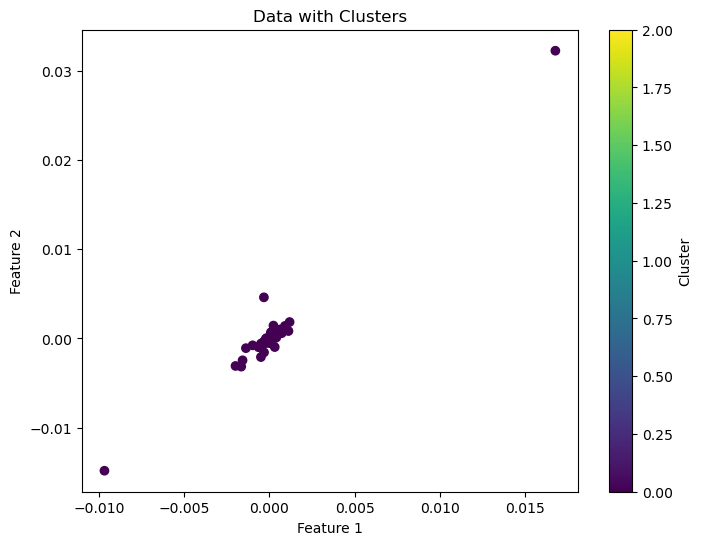

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(sampled_data[:, 0], sampled_data[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data with Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [20]:
y, sr = librosa.load('data/ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr , n_mfcc=40)
mfccs = np.mean(mfccs.T,axis= 0)

display(y.shape)
display(mfccs.shape)
display(mfccs.shape)

(72838,)

(40,)

(40,)

In [ ]:
# Prepare Data

# Extract Time-domain features
# rms_mean, rms_var, rms_freg, rms_cross, 
rms, rms_features = lib.GetRmsFeatures(sampled_data)
#zcr_meanT,zcr_varT,zcr_crossT,zcr_maxT,zcr_argmaxT,zcr_sumT,zcr_meanF,zcr_varF,zcr_crossF,zcr_maxF,zcr_argmaxF,zcr_sumF = lib.GetFeaturesFromTimeDomain(librosa.feature.zero_crossing_rate(y=sampled_data)[:,0])

# Extract Frequency-domain features
'''
sp_cent_mean, sp_cent_var, sp_cent_freg, sp_cent_cross = lib.GetMeanVarFreqCrossFromTimeDomain(librosa.feature.spectral_centroid(y=sampled_data)[:,0])
sp_bw_mean, sp_bw_var, sp_bw_freg, sp_bw_cross = lib.GetMeanVarFreqCrossFromTimeDomain(librosa.feature.spectral_bandwidth(y=sampled_data)[:,0])
sp_cont_mean, sp_cont_var, sp_cont_freg, sp_cont_cross = lib.GetMeanVarFreqCrossFromTimeDomain(librosa.feature.spectral_contrast(y=sampled_data)[:,0])
sp_flat_mean, sp_flat_var, sp_flat_freg, sp_flat_cross = lib.GetMeanVarFreqCrossFromTimeDomain(librosa.feature.spectral_flatness(y=sampled_data)[:,0])
sp_rof_mean, sp_rof_var, sp_rof_freg, sp_rof_cross = lib.GetMeanVarFreqCrossFromTimeDomain(librosa.feature.spectral_rolloff(y=sampled_data)[:,0])
tonnetz_mean, tonnetz_var, tonnetz_freg, tonnetz_cross = lib.GetMeanVarFreqCrossFromTimeDomain(librosa.feature.tonnetz(y=sampled_data)[:,0])
'''
'''
#featured_data = ExtractMelFeatures(sampled_data)
mfcc_data = librosa.feature.mfcc(y=sampled_data, n_mfcc=128)
display(mfcc_data.shape)
delta1_mfcc_data = librosa.feature.delta(mfcc_data,order=2)
display(delta1_mfcc_data.shape)
delta2_mfcc_data = librosa.feature.delta(delta1_mfcc_data,order=2)
display(delta2_mfcc_data.shape)
'''

featured_data = np.concatenate((rms_features['meanT'],
                                rms_features['varT'],
                                rms_features['crossT'],
                                rms_features['maxT'],
                                rms_features['argmaxT'],
                                rms_features['sumT'],
                                rms_features['meanF'],
                                rms_features['varF'],
                                rms_features['crossF'],
                                rms_features['maxF'],
                                rms_features['argmaxF'],
                                rms_features['sumF']),axis=1)
#featured_data = np.concatenate((rms_mean,rms_var,rms_freg,rms_cross,rms_argmaxT,rms_sum,rms_argmaxF,zcr_mean,zcr_var,zcr_freg,zcr_cross,sp_cent_mean, sp_cent_var, sp_cent_freg, sp_cent_cross,sp_bw_mean, sp_bw_var, sp_bw_freg, sp_bw_cross,sp_cont_mean, sp_cont_var, sp_cont_freg, sp_cont_cross,sp_flat_mean, sp_flat_var, sp_flat_freg, sp_flat_cross,sp_rof_mean, sp_rof_var, sp_rof_freg, sp_rof_cross,tonnetz_mean, tonnetz_var, tonnetz_freg, tonnetz_cross),axis=1)

# Prepare Data
featured_data_selected,labels_selected = lib.PrepareBinaryCategoryData(featured_data,labels)
#featured_data_selected,labels_selected = lib.PrepareAllCategoryData(featured_data,labels)
train_data,train_labels,test_data,test_labels = lib.PlotSplitData(featured_data_selected,labels_selected,trainRatio=0.8)
display(train_data.shape)
display(train_labels.shape)
display(test_data.shape)
display(test_labels.shape)

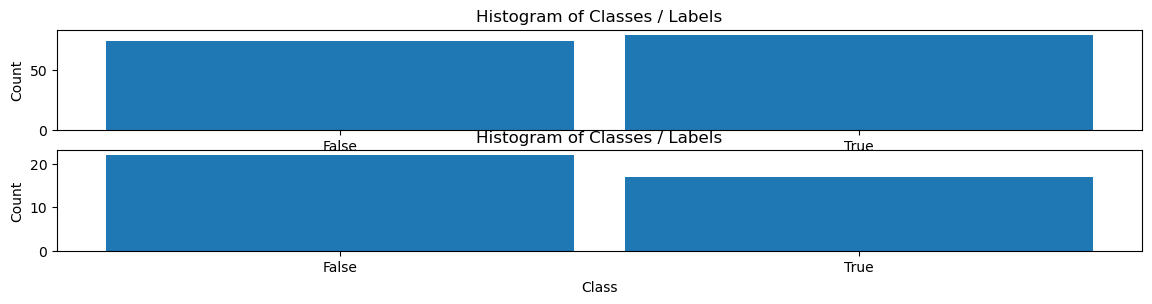

(153, 12)

(153,)

(39, 12)

(39,)

In [19]:
# Feature extraction from librosa for binary classification

from math import floor

def GetSubFeatures(feat):
    meanT = np.mean(feat,axis=1).reshape(feat.shape[0],1)
    varT = np.var(feat,axis=1).reshape(feat.shape[0],1)
    crossT = np.zeros([feat.shape[0],1])
    for ii in range(feat.shape[0]):
        crossT[ii] = np.correlate(feat[ii],feat[ii])
    maxT = np.max(feat,axis=1).reshape(feat.shape[0],1)
    argmaxT = np.argmax(feat,axis=1).reshape(feat.shape[0],1)
    sumT = np.sum(feat,axis=1).reshape(feat.shape[0],1)
    rms_normalized = lib.Normalize(feat)
    rms_normalized_fft = np.abs(np.fft.fft(rms_normalized))
    rms_normalized_fft = rms_normalized_fft[:,:(int)(len(rms_normalized_fft)/2)]
    meanF = np.mean(rms_normalized_fft,axis=1).reshape(feat.shape[0],1)
    varF = np.var(rms_normalized_fft,axis=1).reshape(feat.shape[0],1)
    crossF = np.zeros([rms_normalized_fft.shape[0],1])
    for ii in range(rms_normalized_fft.shape[0]):
        crossF[ii] = np.correlate(rms_normalized_fft[ii],rms_normalized_fft[ii])
    maxF = np.max(rms_normalized_fft,axis=1).reshape(feat.shape[0],1)
    argmaxF = np.argmax(rms_normalized_fft,axis=1).reshape(feat.shape[0],1)
    sumF = np.sum(rms_normalized_fft,axis=1).reshape(feat.shape[0],1)
    return rms_normalized, {'meanT':lib.Normalize(meanT),'varT':lib.Normalize(varT),'crossT':lib.Normalize(crossT),'maxT':lib.Normalize(maxT),'argmaxT':lib.Normalize(argmaxT),'sumT':lib.Normalize(sumT),'meanF':lib.Normalize(meanF),'varF':lib.Normalize(varF),'crossF':lib.Normalize(crossF),'maxF':lib.Normalize(maxF),'argmaxF':lib.Normalize(argmaxF),'sumF':lib.Normalize(sumF)}

def GetEnvelope(data,frame_size=2048,hop_length=512):
    max = np.zeros([data.shape[0],(int)(floor((data.shape[1]-frame_size)/hop_length))])
    for ii in range(0,data.shape[1]-frame_size-hop_length,hop_length):
        frame = data[:,ii:ii+frame_size]
        max[:,(int)(ii/hop_length)] = np.max(frame,axis=1)
    return max

rms, rms_features = GetSubFeatures(librosa.feature.rms(y=lib.Normalize(sampled_data),hop_length=HOP_LENGTH)[:,0])
mfcc, mfcc_features = GetSubFeatures(librosa.feature.mfcc(y=lib.Normalize(sampled_data),hop_length=HOP_LENGTH)[:,0])
poly, poly_features = GetSubFeatures(librosa.feature.poly_features(y=lib.Normalize(sampled_data),hop_length=HOP_LENGTH)[:,0])
ftempo, ftempo_features = GetSubFeatures(librosa.feature.fourier_tempogram(y=lib.Normalize(sampled_data),hop_length=HOP_LENGTH)[:,0])
#ftempo, ftempo_features = GetSubFeatures(GetEnvelope(lib.Normalize(sampled_data),hop_length=HOP_LENGTH))

featured_data = np.concatenate((
    #rms_features['meanT'],rms_features['varT'],rms_features['crossT'],rms_features['maxT'],rms_features['argmaxT'],rms_features['sumT'],
    #rms_features['meanF'],rms_features['varF'],rms_features['crossF'],rms_features['maxF'],rms_features['argmaxF'],rms_features['sumF'],
    #mfcc_features['meanT'],mfcc_features['varT'],mfcc_features['crossT'],mfcc_features['maxT'],mfcc_features['argmaxT'],mfcc_features['sumT'],
    #mfcc_features['meanF'],mfcc_features['varF'],mfcc_features['crossF'],mfcc_features['maxF'],mfcc_features['argmaxF'],mfcc_features['sumF'],
    #poly_features['meanT'],poly_features['varT'],poly_features['crossT'],poly_features['maxT'],poly_features['argmaxT'],poly_features['sumT'],
    #poly_features['meanF'],poly_features['varF'],poly_features['crossF'],poly_features['maxF'],poly_features['argmaxF'],poly_features['sumF'],
    ftempo_features['meanT'],ftempo_features['varT'],ftempo_features['crossT'],ftempo_features['maxT'],ftempo_features['argmaxT'],ftempo_features['sumT'],
    ftempo_features['meanF'],ftempo_features['varF'],ftempo_features['crossF'],ftempo_features['maxF'],ftempo_features['argmaxF'],ftempo_features['sumF'],
    ),axis=1)
featured_data_selected,labels_selected = lib.PrepareBinaryCategoryData(featured_data,labels)
#featured_data_selected,labels_selected = lib.PrepareAllCategoryData(featured_data,labels)
train_data,train_labels,test_data,test_labels = lib.PlotSplitData(featured_data_selected,labels_selected,trainRatio=0.8)
display(train_data.shape)
display(train_labels.shape)
display(test_data.shape)
display(test_labels.shape)

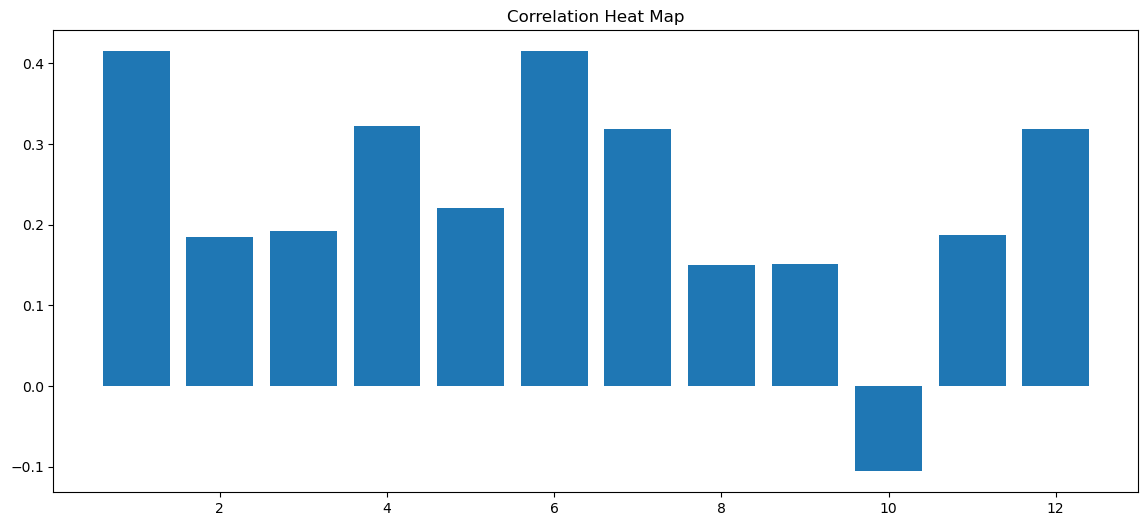

In [20]:
lib.PlotCorrMap(train_data, train_labels)

Prediction Train Accuracy: 99.35 %
Prediction Test Accuracy: 76.92 %


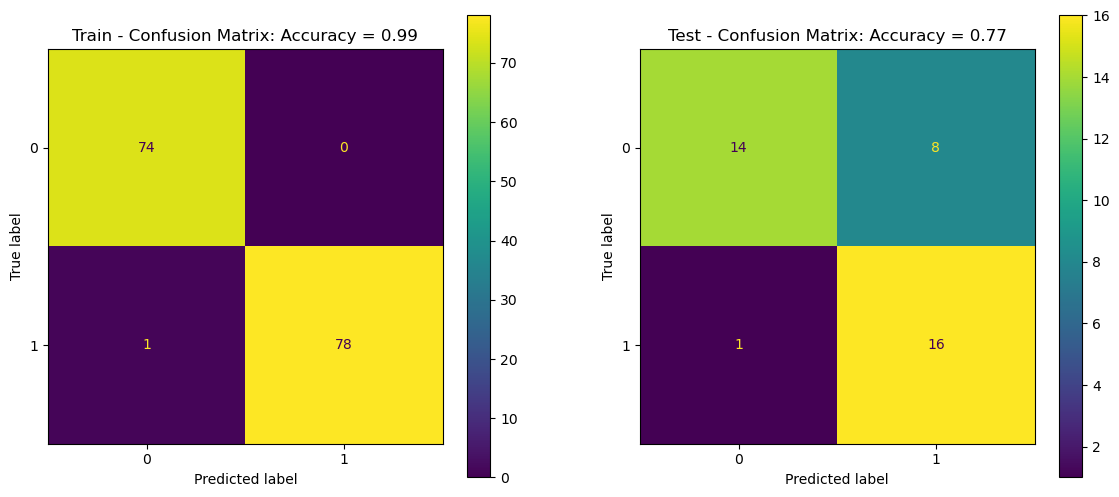

In [6]:
# Test for binary classification
train_data = train_data.real
test_data = test_data.real
lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, n_estimators=100,min_samples_split=6,random_state=1)

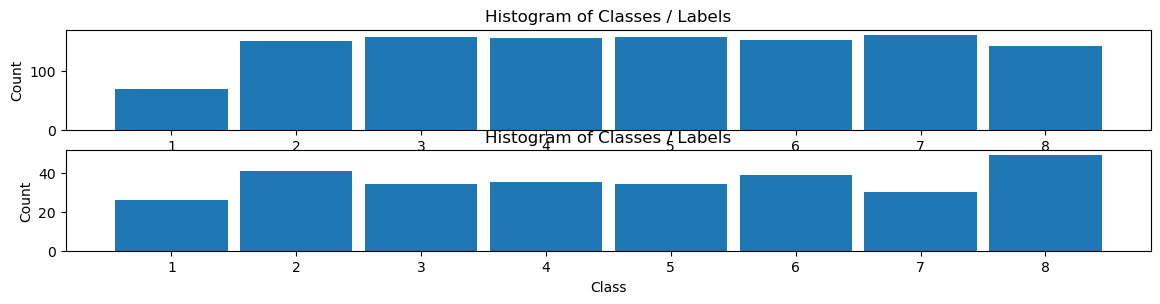

(1152, 48)

(1152,)

(288, 48)

(288,)

In [7]:
# ... for milty classification

featured_data_selected,labels_selected = lib.PrepareAllCategoryData(featured_data,labels)
train_data,train_labels,test_data,test_labels = lib.PlotSplitData(featured_data_selected,labels_selected,trainRatio=0.8)
display(train_data.shape)
display(train_labels.shape)
display(test_data.shape)
display(test_labels.shape)

c:\ProgramData\anaconda3\envs\MyEnv\Lib\site-packages\pandas\core\internals\managers.py:1687: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)


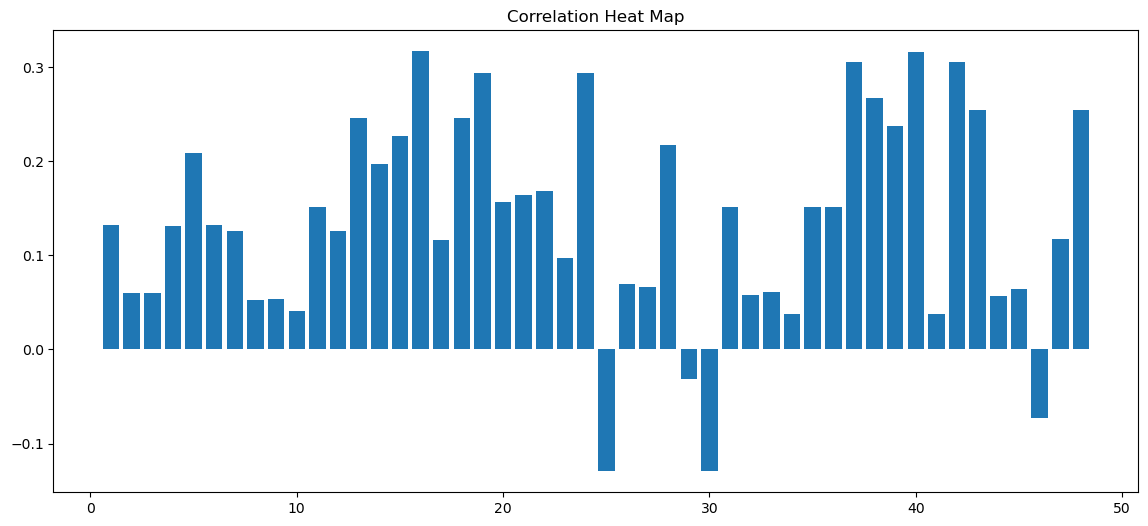

In [8]:
lib.PlotCorrMap(train_data, train_labels)

Prediction Train Accuracy: 99.31 %
Prediction Test Accuracy: 44.44 %


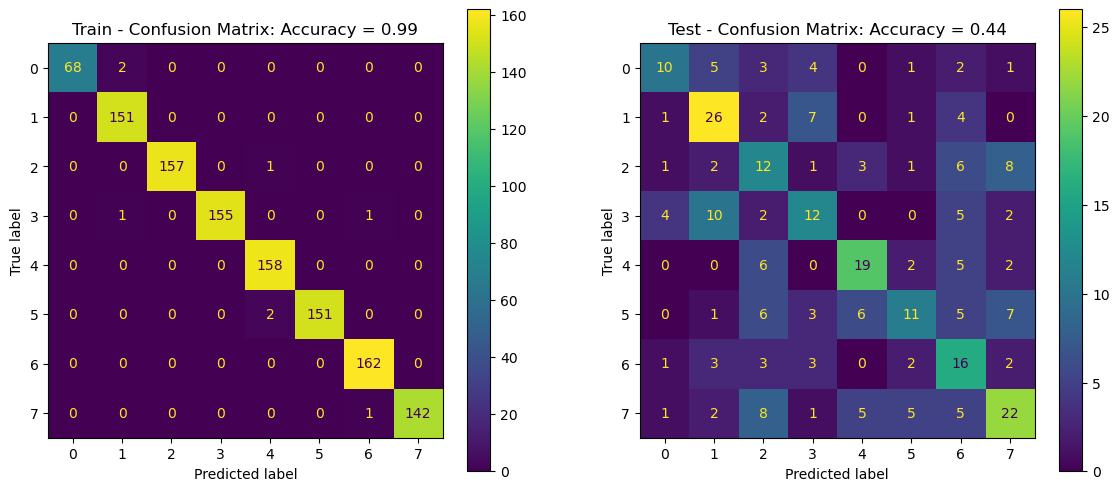

In [9]:
# Test for binary classification
train_data = train_data.real
test_data = test_data.real
lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, n_estimators=100,min_samples_split=6,random_state=1)

### Pair Plot

In [ ]:
# lib.PlotMultiClassData(train_data[:100,-2:], train_labels[:100], axisTitle = 'Training Set')

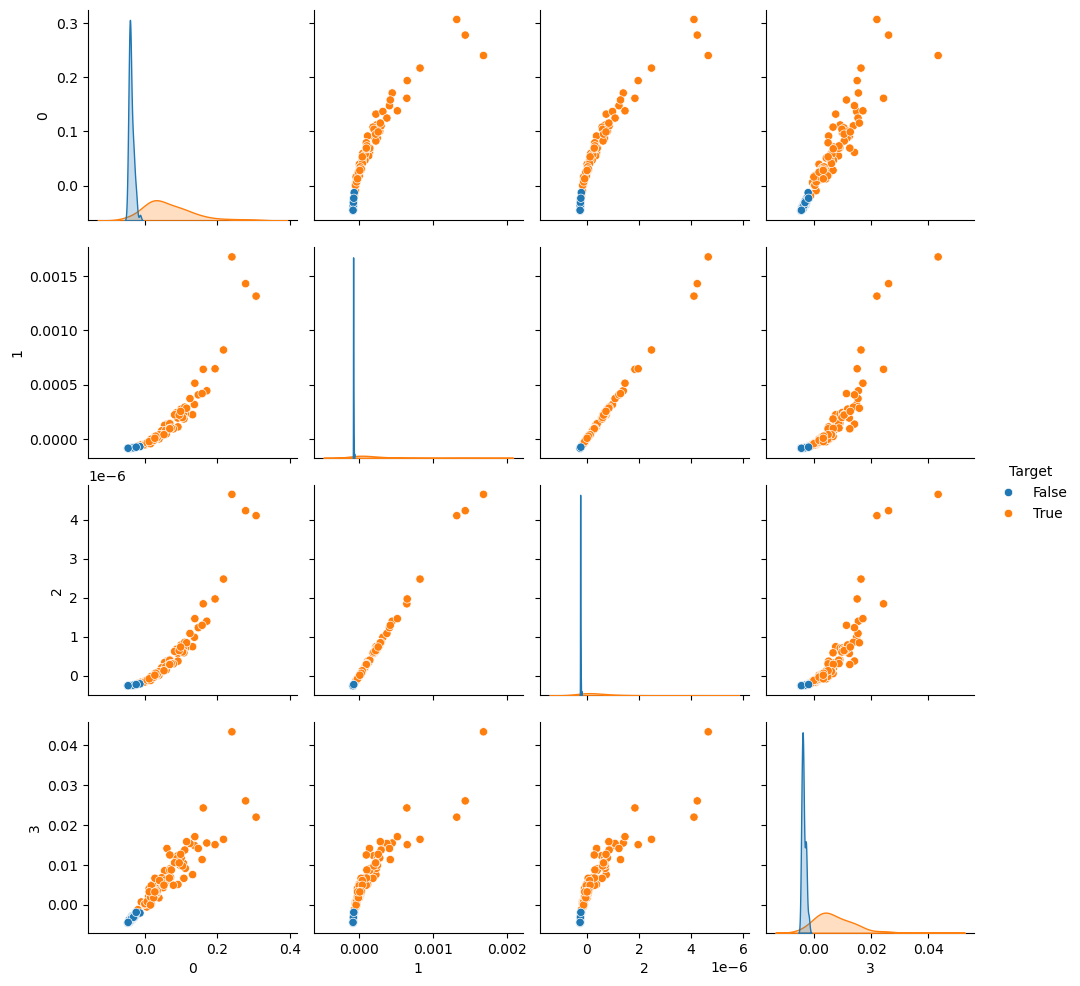

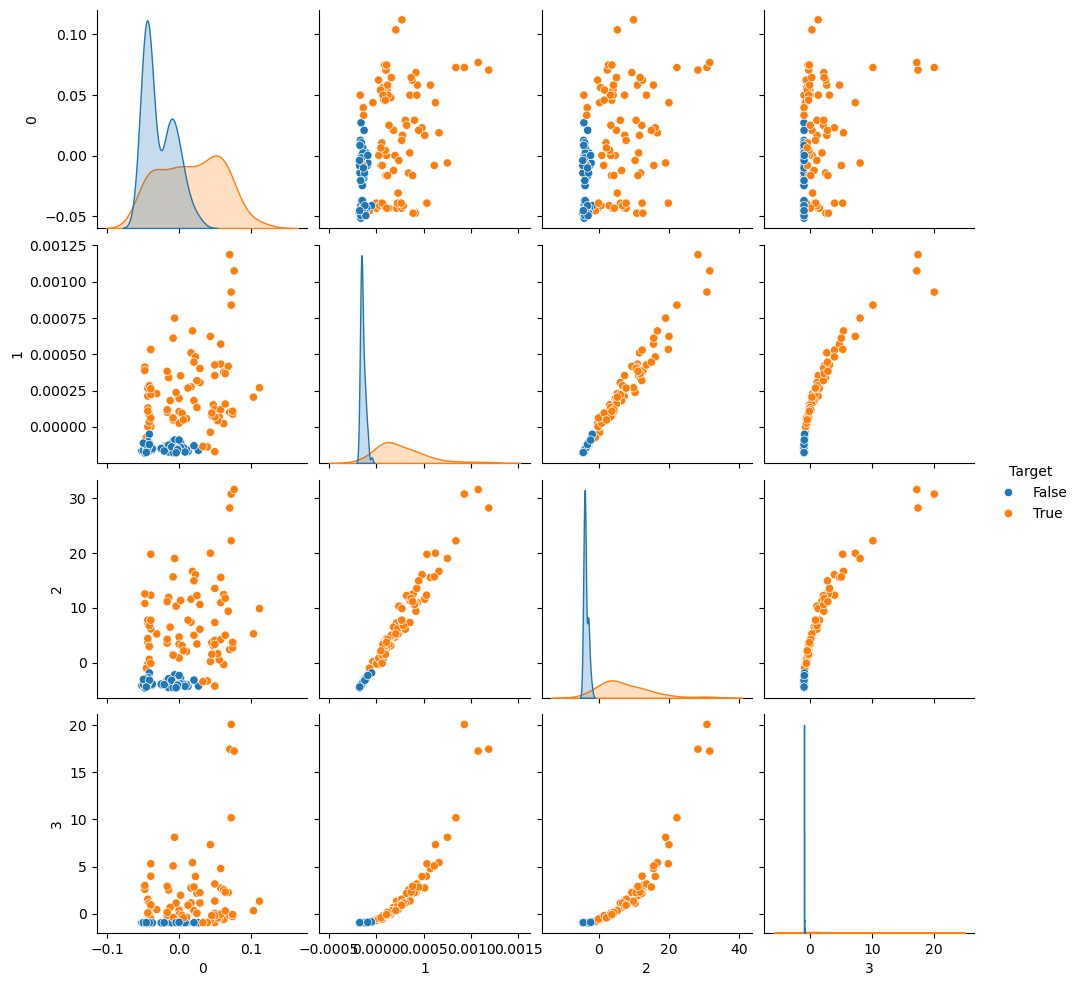

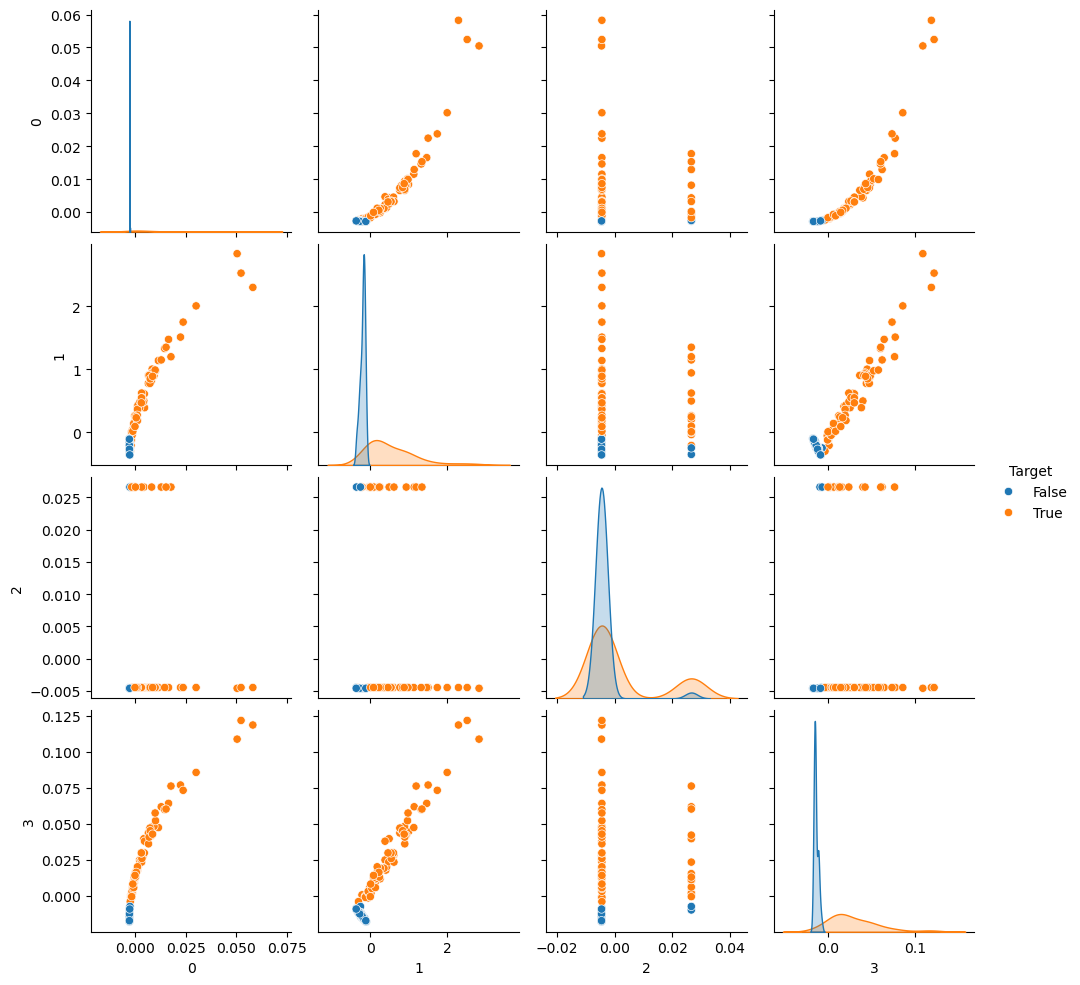

In [ ]:
lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])

### Simple Classification

In [33]:
train_data = train_data.real
test_data = test_data.real

Prediction Train Accuracy: 99.31 %
Prediction Test Accuracy: 44.44 %


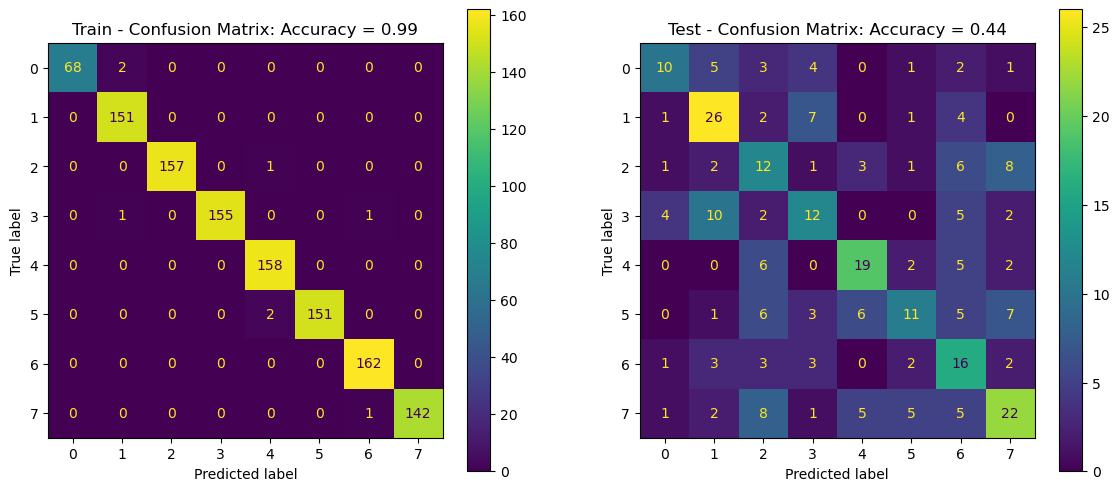

In [36]:
lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, n_estimators=100,min_samples_split=6,random_state=1)

### Search for best Classifier (with different hyperparameters)

In [ ]:
# FindBestClassifier(train_data,train_labels,test_data,test_labels ,lK=np.array([1,3,5,10,20,100]),lC=np.array([0.1,0.3,1,5,10,50]))
lib.GridSearchClassifier(train_data,train_labels,test_data,test_labels)

### Feature Importance

c:\ProgramData\anaconda3\envs\MyEnv\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Study\TechnionAI\Victor\VoiceEmotionalAnalysis\VictorLib.py:153: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


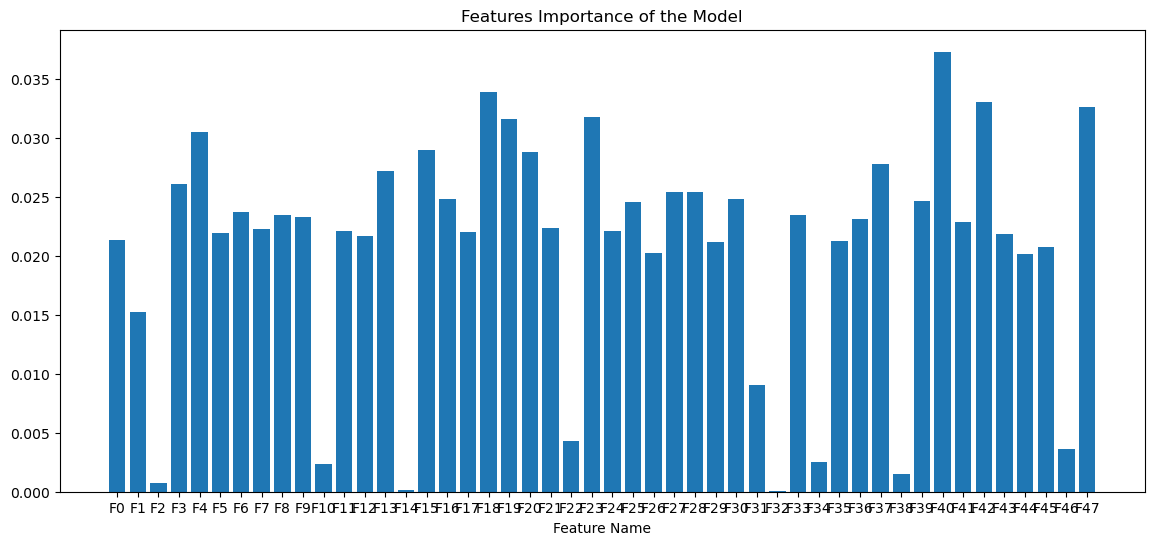

In [45]:
# Feature Importance (After selecting a model - trying to reduce unimportant features)
lib.FeaturesImportance(train_data,train_labels)